X_final shape: (2915, 5, 16)
y_final shape: (2915, 1)
Epoch 1/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0215
Epoch 2/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0189
Epoch 3/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0182
Epoch 4/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0186
Epoch 5/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0177
Epoch 6/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0184
Epoch 7/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0179
Epoch 8/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0183
Epoch 9/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0182
Epoch 10/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0177
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0191  
Loss: 0.018243351951241493
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


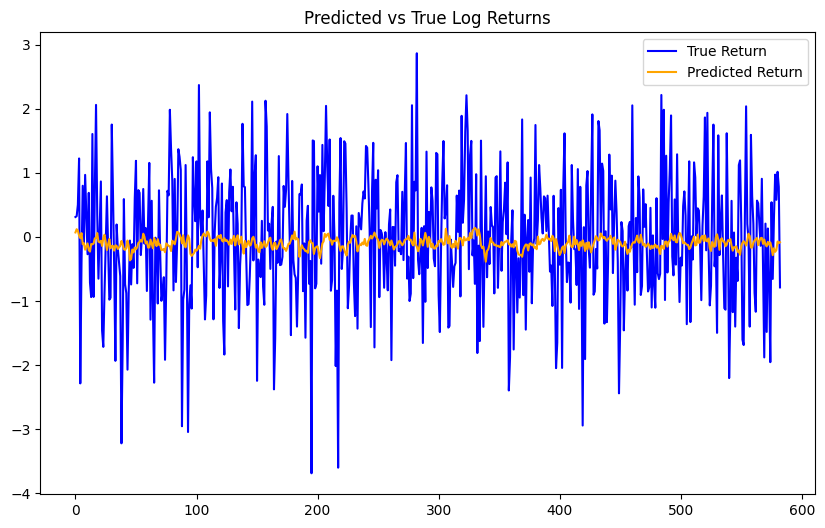

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
import matplotlib.pyplot as plt

# Função para criar o dataset
def create_dataset(N, w, days=2920):
    np.random.seed(42)
    data = np.random.randn(days + w, N)
    attributes = np.zeros((days, N * w))
    
    for i in range(days):
        for j in range(N):
            attributes[i, j*w:(j+1)*w] = data[i:i+w, j][::-1]
    
    crypto1_age = np.arange(1, days + 1).reshape(-1, 1)
    attributes = np.hstack([attributes, crypto1_age])
    target = data[w:days+w, 0]  # Retorno logarítmico t-1 de cripto1
    columns = [f'return_crypto{i+1}_t-{j+1}' for i in range(N) for j in range(w)] + ['crypto1_age']
    df = pd.DataFrame(attributes, columns=columns)
    df['log_return_target'] = target
    return df

# Criando o dataset
N = 3
w = 5
df = create_dataset(N, w)

# Separando as variáveis de entrada (X) e o valor alvo (y)
X = df.drop(columns=['log_return_target']).values
y = df['log_return_target'].values

# Normalizando os dados
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Convertendo os dados para o formato necessário pela LSTM (samples, timesteps, features)
X_final = []
y_final = []

for i in range(len(X_scaled) - w):
    X_final.append(X_scaled[i:i + w])
    y_final.append(y_scaled[i + w])

X_final = np.array(X_final)
y_final = np.array(y_final)

# Verificando as formas
print(f'X_final shape: {X_final.shape}')  # Deve ser (2915, 5, 16)
print(f'y_final shape: {y_final.shape}')  # Deve ser (2915, 1)

# Dividindo entre conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, shuffle=False)

# Criando o modelo LSTM
model = Sequential()
model.add(Input(shape=(w, X_final.shape[2])))  # Ajuste de acordo com a última dimensão de X_final
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(1))

# Compilando o modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Treinando o modelo
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Avaliando o modelo
loss = model.evaluate(X_test, y_test)
print(f"Loss: {loss}")

# Fazendo previsões
y_pred = model.predict(X_test)

# Revertendo a normalização dos resultados
y_pred_rescaled = scaler_y.inverse_transform(y_pred)
y_test_rescaled = scaler_y.inverse_transform(y_test)

# Visualizando as previsões
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='True Return', color='blue')
plt.plot(y_pred_rescaled, label='Predicted Return', color='orange')
plt.legend()
plt.title('Predicted vs True Log Returns')
plt.show()
